# Building A Handwritten Digits Classifier

In this project, we will explore the effectiveness of deep, feedforward neural networks at classifying images. To do so, we will use Scikit-learn's preloaded `sklearn.datasets`, particularly the `load_digits()` [function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). This function returns a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

We will start by visualising some of the data in the dataset.

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

In [149]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [150]:
labels = pd.Series(digits['target'])
data = digits['data']

In [151]:
data_df = pd.DataFrame(data)
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


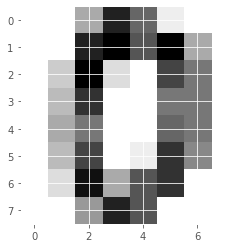

In [152]:
first_image = data_df.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)
plt.imshow(np_image, cmap='gray_r')
plt.show()

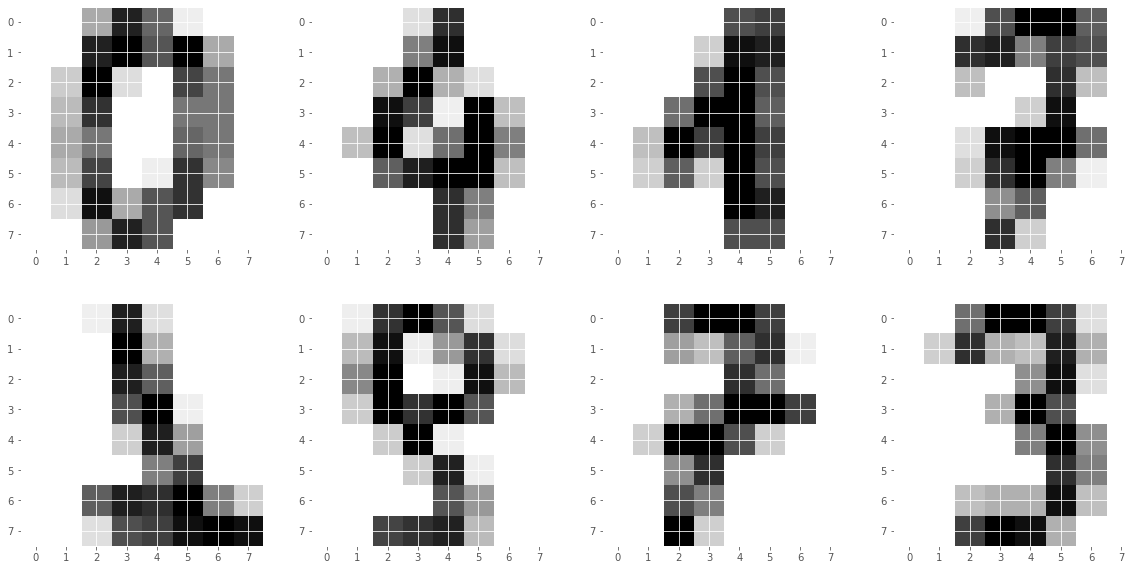

In [153]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
ax[0,0].imshow(data_df.iloc[0].values.reshape(8,8), cmap='gray_r')
ax[0,1].imshow(data_df.iloc[100].values.reshape(8,8), cmap='gray_r')
ax[0,2].imshow(data_df.iloc[200].values.reshape(8,8), cmap='gray_r')
ax[0,3].imshow(data_df.iloc[300].values.reshape(8,8), cmap='gray_r')
ax[1,0].imshow(data_df.iloc[1000].values.reshape(8,8), cmap='gray_r')
ax[1,1].imshow(data_df.iloc[1100].values.reshape(8,8), cmap='gray_r')
ax[1,2].imshow(data_df.iloc[1200].values.reshape(8,8), cmap='gray_r')
ax[1,3].imshow(data_df.iloc[1300].values.reshape(8,8), cmap='gray_r')
plt.show()

## K-Nearest Neighbors Model

In [154]:
def train(n, train_features, train_labels):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(train_features, train_labels)
    return model

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

def cross_validate(k):
    train_accuracies = []
    test_accuracies = []
    kf = KFold(n_splits=4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data_df):
        train_features = data_df.iloc[train_index]
        train_labels = labels.iloc[train_index]
        test_features = data_df.iloc[test_index]
        test_labels = labels.iloc[test_index]
        model = train(k, train_features, train_labels)
        train_accuracy = test(model, train_features, train_labels)
        test_accuracy = test(model, test_features, test_labels)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    return train_accuracies, test_accuracies


In [155]:
# Test the model with k=1:

train_accuracy_1, test_accuracy_1 = cross_validate(1)
mean_train_1 = np.mean(train_accuracy_1)
mean_test_1 = np.mean(test_accuracy_1)

print('Mean train accuracy witj k=1: {}'.format(mean_train_1))
print('Mean test accuracy witj k=1: {}'.format(mean_test_1))

Mean train accuracy witj k=1: 1.0
Mean test accuracy witj k=1: 0.9888728037614452


In [156]:
# Test the model with k values from 1-10:

train_ten_accuracy = []
test_ten_accuracy = []
k_values = list(range(1,11))

for k in k_values:
    train_a, test_a = cross_validate(k)
    mean_train_accuracy = np.mean(train_a)
    train_ten_accuracy.append(mean_train_accuracy)
    mean_test_accuracy = np.mean(test_a)
    test_ten_accuracy.append(mean_test_accuracy)

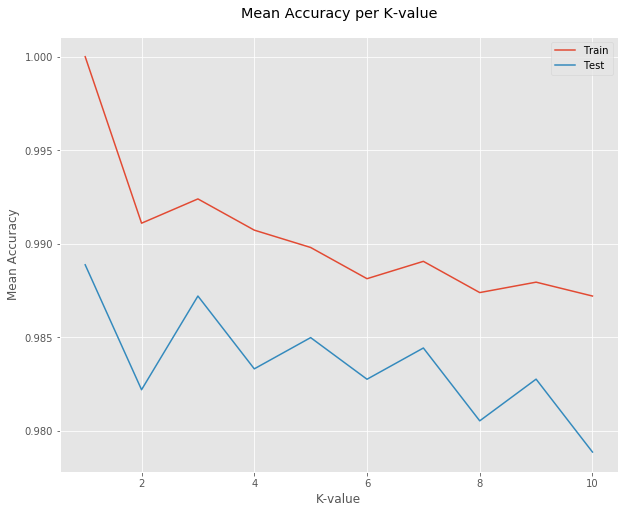

In [157]:
plt.subplots(figsize=(10,8))
plt.plot(k_values, train_ten_accuracy, label='Train')
plt.plot(k_values, test_ten_accuracy, label='Test')
plt.xlabel('K-value')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy per K-value', y=1.03)
plt.legend()
plt.show()

We see that the accuracy of the model decreses with the increase of the k-value.

There are a few downsides to using k-nearest neighbors:

- high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- no model representation to debug and explore

## Neural Network With One Hidden Layer

Let's now try a neural network with a single hidden layer.

In [158]:
def train(hl, train_features, train_labels):
    model = MLPClassifier(hidden_layer_sizes=hl, max_iter=1050)
    model.fit(train_features, train_labels)
    return model

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

def cross_validate(k):
    accuracies = []
    kf = KFold(n_splits=4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data_df):
        train_features = data_df.iloc[train_index]
        train_labels = labels.iloc[train_index]
        test_features = data_df.iloc[test_index]
        test_labels = labels.iloc[test_index]
        model = train(k, train_features, train_labels)
        accuracy = test(model, test_features, test_labels)
        accuracies.append(accuracy)
    return accuracies

In [159]:
one_hidden_layer = [(8,), (16,), (32,), (64,), (128,), (256,)]

one_layer_accuracy = []

for hl in one_hidden_layer:
    accuracy = cross_validate(hl)
    mean_accuracy = np.mean(accuracy)
    one_layer_accuracy.append(mean_accuracy)
    
one_layer_accuracy

[0.9443516456322693,
 0.9543702053947043,
 0.9599381341252164,
 0.9655085374907201,
 0.9721813907448652,
 0.9777443702053947]

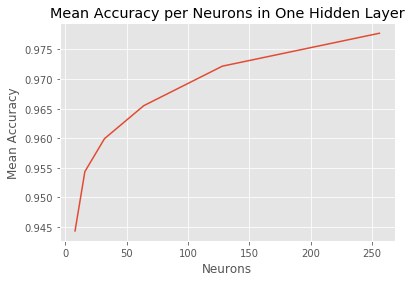

In [160]:
neurons = [8, 16, 32, 64, 128, 256]
plt.plot(neurons, one_layer_accuracy)
plt.xlabel('Neurons')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy per Neurons in One Hidden Layer')
plt.show()

It looks like the average accuracy improved with the increase of neurons in a single hidden layer, achiving 95% accuracy at 256 neurons.

## Neural Network With Two Hidden Layers

Let's try using two hidden layers and continue to increase the number of neurons in each layer.

In [161]:
two_hidden_layers = [(64,64), (128,128), (256, 256)]

two_layer_accuracy = []

for hl in two_hidden_layers:
    accuracy = cross_validate(hl)
    mean_accuracy = np.mean(accuracy)
    two_layer_accuracy.append(mean_accuracy)

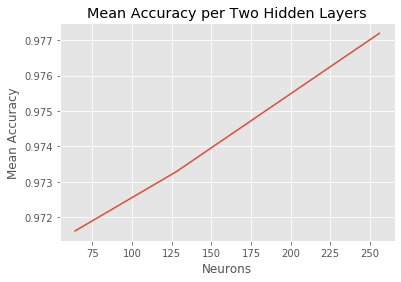

In [162]:
neurons = [x[0] for x in two_hidden_layers]

plt.plot(neurons, two_layer_accuracy)
plt.xlabel('Neurons')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy per Two Hidden Layers')
plt.show()

In [163]:
two_layer_accuracy

[0.9716196486018313, 0.9732937391734718, 0.9771912892848305]

It seems that the accuracy improved slightly, achieving 95.6% at 256 neurons.

## Neural Network With Three Hidden Layers

Using more hidden layers is known to increase the amount of overfitting that happens. To help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6 while testing networks with 3 hidden layers.

In [164]:
def train(hl, train_features, train_labels):
    model = MLPClassifier(hidden_layer_sizes=hl, max_iter=1050)
    model.fit(train_features, train_labels)
    return model

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    return accuracy

def cross_validate(k):
    accuracies = []
    kf = KFold(n_splits=6, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data_df):
        train_features = data_df.iloc[train_index]
        train_labels = labels.iloc[train_index]
        test_features = data_df.iloc[test_index]
        test_labels = labels.iloc[test_index]
        model = train(k, train_features, train_labels)
        accuracy = test(model, test_features, test_labels)
        accuracies.append(accuracy)
    return accuracies

In [165]:
three_hidden_layers = [(10,10,10), (64,64,64), (128,128,128)]

three_layer_accuracy = []

for hl in three_hidden_layers:
    accuracy = cross_validate(hl)
    mean_accuracy = np.mean(accuracy)
    three_layer_accuracy.append(mean_accuracy)

In [166]:
three_layer_accuracy

[0.9515886287625418, 0.9699591230026013, 0.9783054626532888]

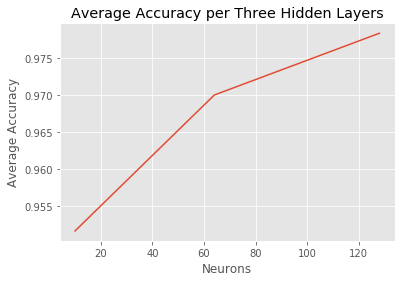

In [167]:
neurons = [x[0] for x in three_hidden_layers]

plt.plot(neurons, three_layer_accuracy)
plt.xlabel('Neurons')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy per Three Hidden Layers')
plt.show()